# Assignment 3 MSDS 422
Regression based models


Linear, Logistic, and other models

#### Background
We're revisiting the same dataset from the past two weeks -- the home equity loan dataset that we cleaned up in Assignment 1. This week, we'll be creating linear models using linear and logisitic regression


#### Set up
Let's start by pulling in all of the packages that we'll need

In [98]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from matplotlib import pyplot as plt

Pull in the dataset from the previous weeks, plus put together the lists of variables from the decision tree, random forest, and gradient boosting models

In [4]:
# I **should** have my .gitignore set up to not upload .xlsx files, so you'll need to change the path here
flag_fn = "HMEQ_Loss_export_flag.xlsx"
flag_df = pd.read_excel(flag_fn)
loss_fn = "HMEQ_Loss_export_loss.xlsx"
loss_df = pd.read_excel(loss_fn)

# get rid of the old indices. I need to remember to remove this when exporting in the future... oh well
flag_df.drop(columns=['Unnamed: 0'], inplace=True)
loss_df.drop(columns=['Unnamed: 0'], inplace=True)


#### Important predictive fields from previous weeks

I could go through and pull in the pickled decision tree etc models for the variable names, but there are so few it doesn't seem worth it

<br>

_Variables used to build the 'Bad Flag' Decision Tree_

['impute_DELINQ', 'impute_VALUE', 'impute_YOJ', 'JOB__Office', 'impute_NINQ', 'impute_CLAGE', 'impute_CLNO', 'impute_LOAN', 'impute_DEROG', 'impute_DEBTINC', 'impute_MORTDUE']


<br>

_Variables used to build the 'Loss Amt' Regression Tree_

['impute_DELINQ', 'impute_VALUE', 'JOB__Self', 'impute_YOJ', 'JOB__Other', 'impute_NINQ', 'impute_CLNO', 'impute_CLAGE', 'impute_LOAN', 'IS_DEBTCON', 'JOB__Mgr', 'JOB__ProfExe', 'impute_DEROG', 'impute_DEBTINC', 'impute_MORTDUE']

<br>
<br>

_'Bad Flag' Random Forest important variables_

['impute_VALUE', 'impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']

<br>

_Loss Prediction important variables_

['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']

<br>
<br>

_'Bad Flag' Gradient Boosting important variables_

['impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_DEBTINC']

<br>

_Loss Prediction important variables_

['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']

<br>

_notice that the random forest and gradient boosting regressors have the same variables. May rerun the code from last assignment to see if I can change that up a little_

In [5]:
# so let's just bring those in as lists. Fortunately it's easy to parse this with vim keybindings, heyo
flag_dt_vars = ['impute_DELINQ', 'impute_VALUE', 'impute_YOJ', 'JOB__Office', 'impute_NINQ', 'impute_CLAGE', 'impute_CLNO', 'impute_LOAN', 'impute_DEROG', 'impute_DEBTINC', 'impute_MORTDUE']
loss_dt_vars = ['impute_DELINQ', 'impute_VALUE', 'JOB__Self', 'impute_YOJ', 'JOB__Other', 'impute_NINQ', 'impute_CLNO', 'impute_CLAGE', 'impute_LOAN', 'IS_DEBTCON', 'JOB__Mgr', 'JOB__ProfExe', 'impute_DEROG', 'impute_DEBTINC', 'impute_MORTDUE']
flag_rf_vars = ['impute_VALUE', 'impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']
loss_rf_vars = ['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']
flag_gb_vars = ['impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_DEBTINC']
loss_gb_vars = ['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']

#### Split the data
We'll go ahead and do the test/train splits up here. Makes it cleaner.

In [6]:
# we'll just keep them as dataframes for now and split the independent/dependent later (easy enough to do with indexing)
train_flag_df, test_flag_df = train_test_split(flag_df, train_size=.9)
train_loss_df, test_loss_df = train_test_split(loss_df, train_size=.9)

## Support functions
Defining functions that we will need to use repeatedly throughout


#### Displaying the ROC curve with AUC values


In [7]:
def ROC_AUC_show(model, data_train_in, data_train_target, data_test_in, data_test_target, plot=True):
    probs=model.predict_proba(data_train_in)[:,1]
    fpr_train, tpr_train, thresh = metrics.roc_curve(data_train_target, probs)
    auc_train = metrics.auc(fpr_train, tpr_train)
    probs=model.predict_proba(data_test_in)[:,1]
    fpr_test, tpr_test, thresh = metrics.roc_curve(data_test_target, probs)
    auc_test = metrics.auc(fpr_test, tpr_test)

    if plot:
        fig,ax = plt.subplots()
        ax.plot(fpr_train,tpr_train, label=f"AUC Train: {auc_train:0.2f}")
        ax.plot(fpr_test,tpr_test, label=f"AUC test: {auc_test:0.2f}")
        ax.legend()
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')

    return fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test

## Logistic Regression
Easy enough stuff, especially with sklearn since we don't have to write our own gradient descent or anything. Nice

Starting with the full input array

In [14]:
flag_log = LogisticRegression(max_iter=10000) # start with the default -- L2 only, non-dual, default alphas for the L2
flag_log.fit(np.array(train_flag_df.drop(columns='TARGET_BAD_FLAG')), np.ravel(train_flag_df[['TARGET_BAD_FLAG']]))

LogisticRegression(max_iter=10000)

In [15]:
train_pred = flag_log.predict(np.array(train_flag_df.drop(columns='TARGET_BAD_FLAG')))
test_pred = flag_log.predict(np.array(test_flag_df.drop(columns='TARGET_BAD_FLAG')))

print(f"Training VAF: {metrics.accuracy_score(np.ravel(train_flag_df[['TARGET_BAD_FLAG']]), train_pred)}")
print(f"testing VAF: {metrics.accuracy_score(np.ravel(test_flag_df[['TARGET_BAD_FLAG']]), test_pred)}")

Training VAF: 0.8038777032065623
testing VAF: 0.7953020134228188


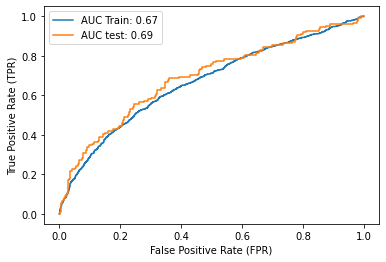

In [16]:
_ = ROC_AUC_show(flag_log, np.array(train_flag_df.drop(columns='TARGET_BAD_FLAG')),\
    np.ravel(train_flag_df[['TARGET_BAD_FLAG']]),\
    np.array(test_flag_df.drop(columns='TARGET_BAD_FLAG')),\
    np.ravel(test_flag_df[['TARGET_BAD_FLAG']]))

Next using only the data from the decision tree

Training VAF: 0.8038777032065623
testing VAF: 0.7953020134228188


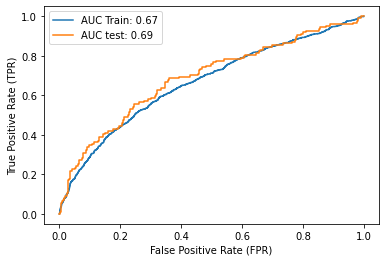

In [18]:
ind_array_train = np.array(train_flag_df[flag_dt_vars])
dep_array_train = np.ravel(train_flag_df[['TARGET_BAD_FLAG']])
ind_array_test = np.array(test_flag_df[flag_dt_vars])
dep_array_test = np.ravel(test_flag_df[['TARGET_BAD_FLAG']])

flag_log = LogisticRegression(max_iter=1000) # start with the default -- L2 only, non-dual, default alphas for the L2
flag_log.fit(ind_array_train, dep_array_train)

train_pred = flag_log.predict(ind_array_train)
test_pred = flag_log.predict(ind_array_test)

print(f"Training VAF: {metrics.accuracy_score(dep_array_train, train_pred)}")
print(f"testing VAF: {metrics.accuracy_score(dep_array_test, test_pred)}")


_ = ROC_AUC_show(flag_log, ind_array_train, dep_array_train, ind_array_test, dep_array_test)

Same for Random Forest

Training VAF: 0.8035048471290082
testing VAF: 0.7885906040268457


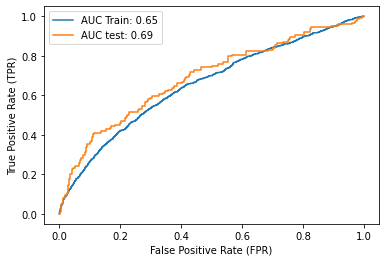

In [19]:
ind_array_train = np.array(train_flag_df[flag_rf_vars])
dep_array_train = np.ravel(train_flag_df[['TARGET_BAD_FLAG']])
ind_array_test = np.array(test_flag_df[flag_rf_vars])
dep_array_test = np.ravel(test_flag_df[['TARGET_BAD_FLAG']])

flag_log = LogisticRegression(max_iter=1000) # start with the default -- L2 only, non-dual, default alphas for the L2
flag_log.fit(ind_array_train, dep_array_train)

train_pred = flag_log.predict(ind_array_train)
test_pred = flag_log.predict(ind_array_test)

print(f"Training VAF: {metrics.accuracy_score(dep_array_train, train_pred)}")
print(f"testing VAF: {metrics.accuracy_score(dep_array_test, test_pred)}")

_ = ROC_AUC_show(flag_log, ind_array_train, dep_array_train, ind_array_test, dep_array_test)

Gradient Boosting

Training VAF: 0.8363161819537659
testing VAF: 0.8305369127516778


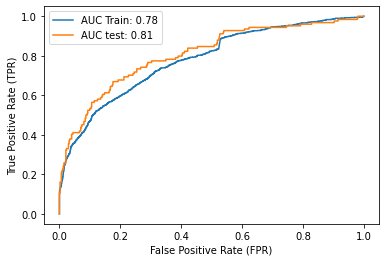

In [20]:
ind_array_train = np.array(train_flag_df[flag_gb_vars])
dep_array_train = np.ravel(train_flag_df[['TARGET_BAD_FLAG']])
ind_array_test = np.array(test_flag_df[flag_gb_vars])
dep_array_test = np.ravel(test_flag_df[['TARGET_BAD_FLAG']])

flag_log = LogisticRegression(max_iter=1000) # start with the default -- L2 only, non-dual, default alphas for the L2
flag_log.fit(ind_array_train, dep_array_train)

train_pred = flag_log.predict(ind_array_train)
test_pred = flag_log.predict(ind_array_test)

print(f"Training VAF: {metrics.accuracy_score(dep_array_train, train_pred)}")
print(f"testing VAF: {metrics.accuracy_score(dep_array_test, test_pred)}")


_ = ROC_AUC_show(flag_log, ind_array_train, dep_array_train, ind_array_test, dep_array_test)

### stepwise selection
Using sequential feature selector

In [142]:
ind_array_train = np.array(train_flag_df.drop(columns='TARGET_BAD_FLAG'))
dep_array_train = np.ravel(train_flag_df[['TARGET_BAD_FLAG']])
ind_array_test = np.array(test_flag_df.drop(columns='TARGET_BAD_FLAG'))
dep_array_test = np.ravel(test_flag_df[['TARGET_BAD_FLAG']])

flag_sfs = SequentialFeatureSelector(LogisticRegression(max_iter=10000),\
    n_features_to_select=9,
    direction='forward',
    scoring='accuracy',
    cv=5)
flag_sfs.fit(ind_array_train, dep_array_train)



SequentialFeatureSelector(estimator=LogisticRegression(max_iter=10000),
                          n_features_to_select=9, scoring='accuracy')

Training accuracy: 0.8015
testing accuracy: 0.7919


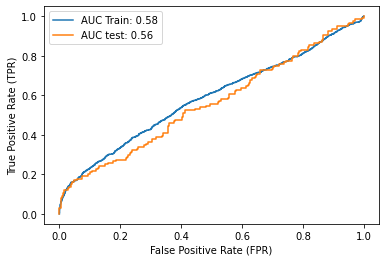

In [144]:
# apparently I have to re-fit the estimator, once it finds the estimator
flag_sfs.estimator.fit(ind_array_train, dep_array_train)

train_pred = flag_sfs.estimator.predict(ind_array_train)
test_pred = flag_sfs.estimator.predict(ind_array_test)

print(f"Training accuracy: {metrics.accuracy_score(dep_array_train, train_pred):.4f}")
print(f"testing accuracy: {metrics.accuracy_score(dep_array_test, test_pred):.4f}")

_ = ROC_AUC_show(flag_sfs.estimator, ind_array_train, dep_array_train, ind_array_test, dep_array_test)

In [128]:
flag_sfs.estimator.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:


var_dict = dict(zip(train_flag_df.drop(columns='TARGET_BAD_FLAG').keys(), flag_mdl.coef_))
print('\n-----------------------------------------------------')
for row in var_dict.keys():
    print(f"{row}:\t{var_dict[row]}")

## Linear Regression

We'll start with just using sklearn. Thinking we'll also just show how to do it with the normal equation, and potentially add some more fun stuff

In [91]:
ind_array_train = np.array(train_loss_df.drop(columns='TARGET_LOSS_AMT'))
dep_array_train = np.ravel(train_loss_df[['TARGET_LOSS_AMT']])
ind_array_test = np.array(test_loss_df.drop(columns='TARGET_LOSS_AMT'))
dep_array_test = np.ravel(test_loss_df[['TARGET_LOSS_AMT']])

loss_mdl = LinearRegression() # start with the default
loss_mdl.fit(ind_array_train, dep_array_train)

train_pred = loss_mdl.predict(ind_array_train)
test_pred = loss_mdl.predict(ind_array_test)

print(f"Training VAF: {metrics.r2_score(dep_array_train, train_pred):.4f},\
    Training RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_train, train_pred)):.4f}")
print(f"testing VAF: {metrics.r2_score(dep_array_test, test_pred):.4f},\
    testing RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_test, test_pred)):.4f})")



var_dict = dict(zip(train_loss_df.drop(columns='TARGET_LOSS_AMT').keys(), loss_mdl.coef_))
print('\n-----------------------------------------------------')
for row in var_dict.keys():
    print(f"{row}:\t{var_dict[row]}")

Training VAF: 0.8265,    Training RMSE: 4529.0424
testing VAF: 0.8351,    testing RMSE: 4261.6279)

-----------------------------------------------------
impute_MORTDUE:	0.001791837818934986
impute_VALUE:	-0.008304188438649789
impute_YOJ:	-87.02227724754634
impute_DEROG:	314.9121078835661
impute_DELINQ:	826.1110820787959
impute_CLAGE:	-22.988617127584153
impute_NINQ:	75.9428396794417
impute_CLNO:	240.21721831980466
impute_DEBTINC:	61.80304662758177
impute_LOAN:	0.7649761516814345
IS_DEBTCON:	1111.6197294087742
JOB__MISSING:	235.32300298011552
JOB__Mgr:	-951.0039661972778
JOB__Office:	-428.5901793321377
JOB__Other:	-568.9963917403626
JOB__ProfExe:	-686.7611746627382
JOB__Sales:	541.0530225884178
JOB__Self:	1858.9756863639836


#### Decision Tree variable set

In [94]:
ind_array_train = np.array(train_loss_df[loss_dt_vars])
dep_array_train = np.ravel(train_loss_df[['TARGET_LOSS_AMT']])
ind_array_test = np.array(test_loss_df[loss_dt_vars])
dep_array_test = np.ravel(test_loss_df[['TARGET_LOSS_AMT']])

loss_mdl = LinearRegression() # start with the default
loss_mdl.fit(ind_array_train, dep_array_train)

train_pred = loss_mdl.predict(ind_array_train)
test_pred = loss_mdl.predict(ind_array_test)

print(f"Training VAF: {metrics.r2_score(dep_array_train, train_pred):.4f},\
    Training RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_train, train_pred)):.4f}")
print(f"testing VAF: {metrics.r2_score(dep_array_test, test_pred):.4f},\
    testing RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_test, test_pred)):.4f})")

var_dict = dict(zip(loss_dt_vars, loss_mdl.coef_))
print('\n-----------------------------------------------------')
for row in var_dict.keys():
    print(f"{row}:\t{var_dict[row]}")

Training VAF: 0.8263,    Training RMSE: 4531.7281
testing VAF: 0.8328,    testing RMSE: 4291.7545)

-----------------------------------------------------
impute_DELINQ:	816.50934744638
impute_VALUE:	-0.008390271129487311
JOB__Self:	2031.4565292103523
impute_YOJ:	-87.74301289560022
JOB__Other:	-394.8559621000501
impute_NINQ:	76.74524433471618
impute_CLNO:	241.74412238864858
impute_CLAGE:	-23.004331022748698
impute_LOAN:	0.764532220710706
IS_DEBTCON:	1121.8281738777894
JOB__Mgr:	-781.5132306296002
JOB__ProfExe:	-518.1694580017863
impute_DEROG:	317.79835569012147
impute_DEBTINC:	62.2180835992852
impute_MORTDUE:	0.00193740459134331


#### Random Forest variable set

In [95]:
ind_array_train = np.array(train_loss_df[loss_rf_vars])
dep_array_train = np.ravel(train_loss_df[['TARGET_LOSS_AMT']])
ind_array_test = np.array(test_loss_df[loss_rf_vars])
dep_array_test = np.ravel(test_loss_df[['TARGET_LOSS_AMT']])

loss_mdl = LinearRegression() # start with the default
loss_mdl.fit(ind_array_train, dep_array_train)

train_pred = loss_mdl.predict(ind_array_train)
test_pred = loss_mdl.predict(ind_array_test)

print(f"Training VAF: {metrics.r2_score(dep_array_train, train_pred):.4f},\
    Training RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_train, train_pred)):.4f}")
print(f"testing VAF: {metrics.r2_score(dep_array_test, test_pred):.4f},\
    testing RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_test, test_pred)):.4f})")


var_dict = dict(zip(loss_rf_vars, loss_mdl.coef_))
print('\n-----------------------------------------------------')
for row in var_dict.keys():
    print(f"{row}:\t{var_dict[row]}")

Training VAF: 0.7706,    Training RMSE: 5207.7079
testing VAF: 0.7854,    testing RMSE: 4862.2888)

-----------------------------------------------------
impute_CLNO:	239.72649493064088
impute_DEBTINC:	72.53064190903183
impute_LOAN:	0.7460053360156526


### Gradient Boosting set

In [96]:
ind_array_train = np.array(train_loss_df[loss_gb_vars])
dep_array_train = np.ravel(train_loss_df[['TARGET_LOSS_AMT']])
ind_array_test = np.array(test_loss_df[loss_gb_vars])
dep_array_test = np.ravel(test_loss_df[['TARGET_LOSS_AMT']])

loss_mdl = LinearRegression() # start with the default
loss_mdl.fit(ind_array_train, dep_array_train)

train_pred = loss_mdl.predict(ind_array_train)
test_pred = loss_mdl.predict(ind_array_test)

print(f"Training VAF: {metrics.r2_score(dep_array_train, train_pred):.4f},\
    Training RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_train, train_pred)):.4f}")
print(f"testing VAF: {metrics.r2_score(dep_array_test, test_pred):.4f},\
    testing RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_test, test_pred)):.4f})")


var_dict = dict(zip(loss_gb_vars, loss_mdl.coef_))
print('\n-----------------------------------------------------')
for row in var_dict.keys():
    print(f"{row}:\t{var_dict[row]}")

Training VAF: 0.7706,    Training RMSE: 5207.7079
testing VAF: 0.7854,    testing RMSE: 4862.2888)

-----------------------------------------------------
impute_CLNO:	239.72649493064088
impute_DEBTINC:	72.53064190903183
impute_LOAN:	0.7460053360156526


### Stepwise selection

In [147]:
ind_array_train = np.array(train_loss_df.drop(columns='TARGET_LOSS_AMT'))
dep_array_train = np.ravel(train_loss_df[['TARGET_LOSS_AMT']])
ind_array_test = np.array(test_loss_df.drop(columns='TARGET_LOSS_AMT'))
dep_array_test = np.ravel(test_loss_df[['TARGET_LOSS_AMT']])

loss_sfs = SequentialFeatureSelector(LinearRegression(),\
    n_features_to_select=5,
    direction='forward',
    scoring='r2',
    cv=5)
loss_sfs.fit(ind_array_train, dep_array_train)

# apparently I have to re-fit the estimator, once it finds the estimator
loss_sfs.estimator.fit(ind_array_train, dep_array_train)

train_pred = loss_sfs.estimator.predict(ind_array_train)
test_pred = loss_sfs.estimator.predict(ind_array_test)

print(f"Training VAF: {metrics.r2_score(dep_array_train, train_pred):.4f},\
    Training RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_train, train_pred)):.4f}")
print(f"testing VAF: {metrics.r2_score(dep_array_test, test_pred):.4f},\
    testing RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_test, test_pred)):.4f})")


Training VAF: 0.8265,    Training RMSE: 4529.0424
testing VAF: 0.8351,    testing RMSE: 4261.6279)


## Linear Regression with the normal function
Since we can go ahead and do that easily

In [88]:
def normal(indep, dep):
    # for some reason getting poor estimates with inv, so using pinv instead
    # I would have guessed that it's because the matrix is poorly conditioned, 
    # but the determinant is way over 0. weird
    return np.matmul(np.linalg.pinv(np.matmul(indep.T,indep)), np.matmul(indep.T, dep))

In [97]:
# pull in desired values
ind_array_train = np.array(train_loss_df.drop(columns='TARGET_LOSS_AMT'))
dep_array_train = np.ravel(train_loss_df[['TARGET_LOSS_AMT']])
ind_array_test = np.array(test_loss_df.drop(columns='TARGET_LOSS_AMT'))
dep_array_test = np.ravel(test_loss_df[['TARGET_LOSS_AMT']])


# add a column for the intercept
ind_array_train = np.append(ind_array_train, np.ones([ind_array_train.shape[0],1]), axis=1)
ind_array_test = np.append(ind_array_test, np.ones([ind_array_test.shape[0],1]), axis=1)

# calculate the coefficients
B_array = normal(ind_array_train, dep_array_train)

# find the prediction values
train_pred = np.matmul(ind_array_train, B_array)
test_pred = np.matmul(ind_array_test, B_array)

# and errors
print(f"Training VAF: {metrics.r2_score(dep_array_train, train_pred)},\
    training RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_train, train_pred))}")
print(f"testing VAF: {metrics.r2_score(dep_array_test, test_pred)},\
    testing RMSE: {np.sqrt(metrics.mean_squared_error(dep_array_test, test_pred))}")

var_dict = dict(zip(train_loss_df.drop(columns='TARGET_LOSS_AMT').keys(), B_array[:-1]))
print("\n-----------------------------------------------------")
for row in var_dict.keys():
    print(f"{row}:\t{var_dict[row]}")

Training VAF: 0.8264605613793605,    training RMSE: 4529.04241282902
testing VAF: 0.8351154969704642,    testing RMSE: 4261.627884314475

-----------------------------------------------------
impute_MORTDUE:	0.0017918378189524103
impute_VALUE:	-0.0083041884386648
impute_YOJ:	-87.02227724670979
impute_DEROG:	314.9121078838998
impute_DELINQ:	826.1110820784579
impute_CLAGE:	-22.988617127591112
impute_NINQ:	75.94283967952742
impute_CLNO:	240.21721831977902
impute_DEBTINC:	61.80304662757305
impute_LOAN:	0.7649761516814417
IS_DEBTCON:	1111.6197294080484
JOB__MISSING:	-213.76316162475268
JOB__Mgr:	-1400.0901308032749
JOB__Office:	-877.6763439380939
JOB__Other:	-1018.082556346184
JOB__ProfExe:	-1135.8473392693231
JOB__Sales:	91.9668579819845
JOB__Self:	1409.8895217598638
